In [2]:
# Julia 1.1.1, May 2019
# Prototype and test different code constructs to manipulate particle ensembles
# - efficiently
# - intuitively

In [4]:
using Pkg
Pkg.add("StatsBase"); using StatsBase
Pkg.add("LinearAlgebra"); using LinearAlgebra
Pkg.add("Distributed"); using Distributed
Pkg.add("PyPlot"); using PyPlot

 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]


In [9]:
# define a data type for particle filtering
# T is the type for the state space of the particles
abstract type ParticleEnsemble{T} end;

mutable struct UnweightedParticleEnsemble{T} <: ParticleEnsemble{T}
    positions::Array{T,1}
    size::Int64
    gain::Array{T,1}
    potential::Array{Float64,1}
end;

mutable struct WeightedParticleEnsemble{T} <: ParticleEnsemble{T}
    positions::Array{T,1}
    weights::ProbabilityWeights # built-in type that stores the sum of weights as weights.sum
    size::Int64
end;

In [6]:
subtypes(ParticleEnsemble)

2-element Array{Any,1}:
 UnweightedParticleEnsemble
 WeightedParticleEnsemble  

In [8]:
function AddWeights(ensemble::UnweightedParticleEnsemble)
    WeightedParticleEnsemble(ensemble.positions, ProbabilityWeights(ones(ensemble.size)), ensemble.size)
end;

function RemoveWeights(ensemble::WeightedParticleEnsemble)
    temp_ensemble=copy(ensemble)
    Resample!(temp_ensemble)
    UnweightedParticleEnsemble(temp_ensemble.positions, temp_ensemble.size)
end;

### Generate ensembles

In [12]:
N=10_000_000
weighted_ensemble=WeightedParticleEnsemble(randn(N),ProbabilityWeights(rand(N)),N);
unweighted_ensemble=UnweightedParticleEnsemble(randn(N),N,randn(N),randn(N));

### Resampling

In [8]:
# resample with replacement from the particle positions with probabilities proportional to the particle weights
# reset the weights to 1
function Resample!(ensemble::WeightedParticleEnsemble)
    ensemble.positions=sample(ensemble.positions, ensemble.weights, ensemble.size; replace=true, ordered=false)
    ensemble.weights=ProbabilityWeights(ones(ensemble.size))
end;

In [24]:
weighted_ensemble=WeightedParticleEnsemble(randn(N),ProbabilityWeights(rand(N)),N);
@time Resample!(weighted_ensemble);

  1.444163 seconds (18 allocations: 457.764 MiB, 15.03% gc time)


In [25]:
@time weighted_ensemble.weights.sum

  0.000092 seconds (84 allocations: 5.141 KiB)


1.0e7

In [15]:
# Calling Resample! on UnweightedParticleEnsemble produces an error
Resample!(unweighted_ensemble)

MethodError: MethodError: no method matching Resample!(::UnweightedParticleEnsemble{Float64})
Closest candidates are:
  Resample!(!Matched::WeightedParticleEnsemble) at In[8]:4

### Add and remove weights

In [12]:
@time AddWeights(unweighted_ensemble)

  0.033344 seconds (13.02 k allocations: 76.928 MiB, 12.38% gc time)


WeightedParticleEnsemble{Float64}([-0.124948, 0.156508, -0.354942, -1.14672, 0.590922, 0.597742, 0.297599, -0.713978, -0.114206, -0.513938  …  1.27934, 1.24948, -0.737159, 0.499672, 1.12079, -0.949399, -0.522166, -0.6355, -0.115501, -0.348862], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 10000000)

In [97]:
@time RemoveWeights(weighted_ensemble)

MethodError: MethodError: no method matching copy(::WeightedParticleEnsemble{Float64})
Closest candidates are:
  copy(!Matched::Expr) at expr.jl:36
  copy(!Matched::Core.CodeInfo) at expr.jl:64
  copy(!Matched::BitSet) at bitset.jl:46
  ...

### Computing expectations

In [6]:
function ExpectedValue(ensemble::UnweightedParticleEnsemble)
    #sum(ensemble.positions)/ensemble.size
    mean(ensemble.positions)
end;

function ExpectedValue(ensemble::UnweightedParticleEnsemble, fun::Function)
    sum(fun.(ensemble.positions))/ensemble.size
end;

function ExpectedValue(ensemble::WeightedParticleEnsemble)
    dot(ensemble.weights, ensemble.positions)/ensemble.weights.sum
end;

function ExpectedValue(ensemble::WeightedParticleEnsemble, fun::Function)
    dot(ensemble.weights, fun.(ensemble.positions))/ensemble.weights.sum
end;

function ExpectedValueParallel(ensemble::WeightedParticleEnsemble, fun::Function)
    s = @distributed (+) for i = 1:ensemble.size
        @inbounds ensemble.weights[i] * fun(ensemble.positions[i])
    end
    return s/ensemble.weights.sum
end;

In [30]:
@time ExpectedValue(weighted_ensemble)

  0.014874 seconds (7 allocations: 208 bytes)


-0.000519531592988347

In [29]:
@time ExpectedValue(weighted_ensemble, exp)

  0.156885 seconds (11 allocations: 76.294 MiB, 3.91% gc time)


1.6479455357631658

In [16]:
@time ExpectedValue(unweighted_ensemble)

  0.006475 seconds (5 allocations: 176 bytes)


0.0004849596171102774

@time ExpectedValue(unweighted_ensemble, exp)

In [21]:
@time ExpectedValueParallel(weighted_ensemble, exp)

  1.094284 seconds (50.00 M allocations: 762.933 MiB, 2.49% gc time)


1.6487644404800754

In [35]:
Threads.nthreads()

4

# Gain estimation algorithms for unweighted filters

In [ ]:
# GAIN ESTIMATION FOR FPF

In [10]:
# This function applies the gain stored in the ensemble object
function ApplyGain!(ensemble::UnweightedParticleEnsemble, dt::Float64)
   broadcast!(+, ensemble.positions, ensemble.positions, dt .* ensemble.gain) 
end;

## Counting (1d)

In [11]:
function Gain_counting!(ensemble::UnweightedParticleEnsemble, h::Function, p::Function)
    sort!(ensemble.positions)
    H = h.(ensemble.positions)::Array{Float64,1}
    broadcast!(-, H, H, mean(H))
    broadcast!(/, H, H, ensemble.size)
    int = 0.
    for (i,pos) in enumerate(ensemble.positions) 
        int = int + H[i]
        ensemble.gain[i] = -int/p(pos)
    end
end;

## Semigroup method from Taghvaei & Mehta, IEEE CDC, 2016

In [103]:
function Gain_semigroup!(ensemble::UnweightedParticleEnsemble, h::Function)
    epsilon = .1
    N = ensemble.size
    H = zeros(Float64, N)
    broadcast!(h, H, ensemble.positions)
    broadcast!(-, H, H, mean(H))
    broadcast!(*, H, H, epsilon)
    
    # compute T operator
    T = zeros(Float64, N, N)
    for i in 1:N
        for j in i:N
            T[i,j] = exp(-(ensemble.positions[i]-ensemble.positions[j])^2/(4*epsilon))
            T[j,i] = T[i,j]
        end
    end
    broadcast!(/, T, T, sqrt.(sum(T,dims=1) .* sum(T,dims=2)))
    broadcast!(/, T, T, sum(T,dims=2))
    
    # solve fixed-point equation
    newpotential = copy(ensemble.potential)::Array{Float64,1}
    fluctuation = 1.
    while fluctuation > 1E-2
        mul!(newpotential, T, ensemble.potential)
        broadcast!(+, newpotential, newpotential, H)
        broadcast!(-, newpotential, newpotential, mean(newpotential))
        fluctuation = maximum(abs.(newpotential-ensemble.potential))
        ensemble.potential = copy(newpotential)
    end
    
    ensemble.gain = T * (ensemble.potential .* ensemble.positions) - (T*ensemble.potential) .* (T*ensemble.positions)
    broadcast!(/, ensemble.gain, ensemble.gain, 2*epsilon)
end;


function Gain_semigroup!(ensemble::UnweightedParticleEnsemble) # For h(x)=x
    epsilon = .1
    N = ensemble.size
    H = copy(ensemble.positions)
    broadcast!(-, H, H, mean(H))
    broadcast!(*, H, H, epsilon)
    
    # compute T operator
    T = zeros(Float64, N, N)
    for i in 1:N
        for j in i:N
            T[i,j] = exp(-(ensemble.positions[i]-ensemble.positions[j])^2/(4*epsilon))
            T[j,i] = T[i,j]
        end
    end
    broadcast!(/, T, T, sqrt.(sum(T,dims=1) .* sum(T,dims=2)))
    broadcast!(/, T, T, sum(T,dims=2))
    
    # solve fixed-point equation
    newpotential = copy(ensemble.potential)::Array{Float64,1}
    fluctuation = 1.
    while fluctuation > 1E-2
        mul!(newpotential, T, ensemble.potential)
        broadcast!(+, newpotential, newpotential, H)
        broadcast!(-, newpotential, newpotential, mean(newpotential))
        fluctuation = maximum(abs.(newpotential-ensemble.potential))
        ensemble.potential = copy(newpotential)
    end
    
    ensemble.gain = T * (ensemble.potential .* ensemble.positions) - (T*ensemble.potential) .* (T*ensemble.positions)
    broadcast!(/, ensemble.gain, ensemble.gain, 2*epsilon)
end;

### Example

In [13]:
# Settings
function p(x::Float64)
    ( exp(-(x-1)^2/(2*0.16))+exp(-(x+1)^2/(2*0.16)) ) / sqrt(8*pi*0.16)
end;

function h(x::Float64)
    x
end;

In [14]:
# numerical integral over R by transform
function finv(y::Float64)
    return tan(pi*y/2)#log((1+y)/(1-y))
end

function finvprime(y::Float64)
    return pi/(1+cos(pi*y))#2/(1-y^2)
end

function NumIntR(fun::Function, n::Int64)
    x = zeros(Float64, n+1)
    int = zeros(Float64, n+1)
    dy = 2. / (n+1)
    y = -1. -dy/2
    for i = 2:(n+1)
        y = y + dy
        x[i] = finv(y)
        int[i] = int[i-1] + fun(x[i]) * dy * finvprime(y)
    end
    x[2:n+1], int[2:n+1]
end;

In [15]:
xx,int = NumIntR(x -> -x*p(x),1000);
K_exact = int ./ p.(xx);

In [104]:
N=1000
testens=UnweightedParticleEnsemble(vcat(0.4.*randn(div(N,2)).-1,0.4.*randn(div(N,2)).+1),N,randn(N),randn(N));

In [105]:
@time Gain_semigroup!(testens, x->x);
@time Gain_semigroup!(testens);

  0.134423 seconds (347.71 k allocations: 33.874 MiB, 4.81% gc time)
  0.100750 seconds (198.46 k allocations: 24.271 MiB, 2.31% gc time)


In [94]:
@time Gain_counting!(testens, x->x, p);

  0.029927 seconds (147.02 k allocations: 7.557 MiB)


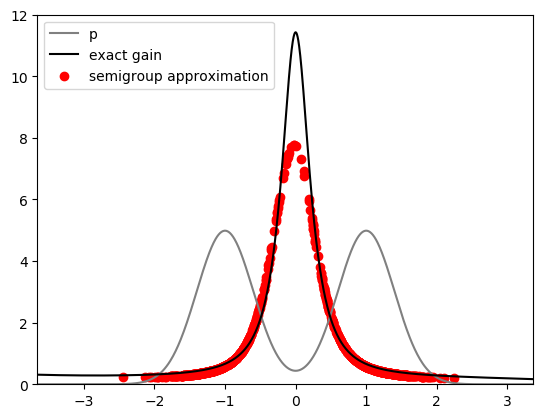

In [106]:
xlim((1.5*minimum(testens.positions),1.5*maximum(testens.positions)))
ylim((0,12))
plot(xx, 10*p.(xx), color="gray");
plot(xx, K_exact, color="black");
scatter(testens.positions, testens.gain, color="red");
#scatter(testens.positions, testens.potential)
#hist(testens.positions,50)
legend(("p","exact gain","semigroup approximation"));

In [27]:
@time ApplyGain!(testens, 1E-2);

  0.000020 seconds (5 allocations: 8.094 KiB)


In [28]:
# simulate sequential gain estimation and update
N=1000
testens=UnweightedParticleEnsemble(vcat(0.4.*randn(div(N,2)).-1,0.4.*randn(div(N,2)).+1),N,randn(N),randn(N));
n_time = 1000 # number of time steps
positions = zeros(n_time,N)
potentials = zeros(n_time,N)
gains = zeros(n_time,N)
@time for i = 1:n_time
    Gain_semigroup!(testens, x->x)
    positions[i,:] = testens.positions
    potentials[i,:] = testens.potential
    gains[i,:] = testens.gain
    ApplyGain!(testens, 1E-2)
end

 13.435330 seconds (628.77 k allocations: 15.079 GiB, 5.44% gc time)


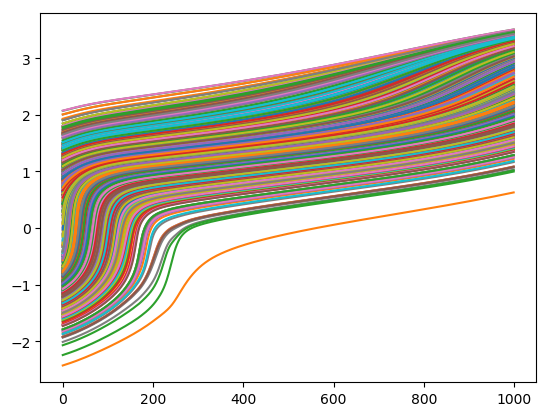

In [29]:
plot(positions[:,:]);

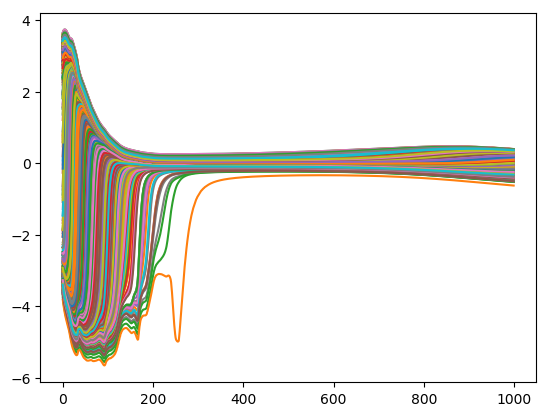

In [30]:
plot(potentials[:,:]);

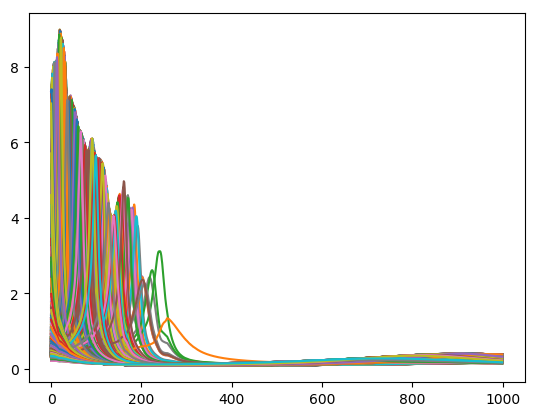

In [31]:
plot(gains[:,:]);